In [1]:
!kaggle datasets download -d fatihkgg/affectnet-yolo-format
!unzip affectnet-yolo-format.zip -d affectnet-yolo-format

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_1989.txt  
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_199.txt  
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_1990.txt  
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_1991.txt  
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_1993.txt  
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_1994.txt  
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_1998.txt  
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_1999.txt  
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_20.txt  
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_200.txt  
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_2000.txt  
  inflating: affectnet-yolo-format/YOLO_format/valid/labels/ffhq_2002.txt  
  inflating: affectnet-y

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.3168 - loss: 1.9768 - precision_1: 0.4568 - recall_1: 0.1039 - val_accuracy: 0.4005 - val_loss: 1.6599 - val_precision_1: 0.7869 - val_recall_1: 0.1290
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3853 - loss: 1.6763 - precision_1: 0.6977 - recall_1: 0.1628 - val_accuracy: 0.4145 - val_loss: 1.6209 - val_precision_1: 0.6770 - val_recall_1: 0.2355
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4158 - loss: 1.6130 - precision_1: 0.6952 - recall_1: 0.1927 - val_accuracy: 0.4473 - val_loss: 1.5823 - val_precision_1: 0.7891 - val_recall_1: 0.1629
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4308 - loss: 1.5690 - precision_1: 0.7362 - recall_1: 0.2022 - val_accuracy: 0.4511 - val_loss: 1.5556 - val_precision_1: 0.7836 - val_recall_1: 0.1849
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4701 - loss: 1.5134 - precision_1: 0.7345 - recall_1: 0.

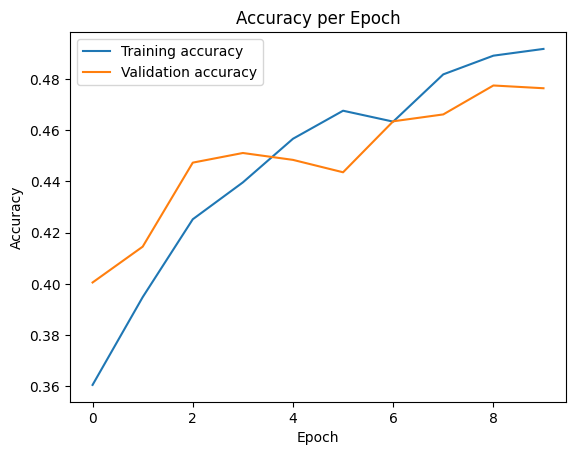

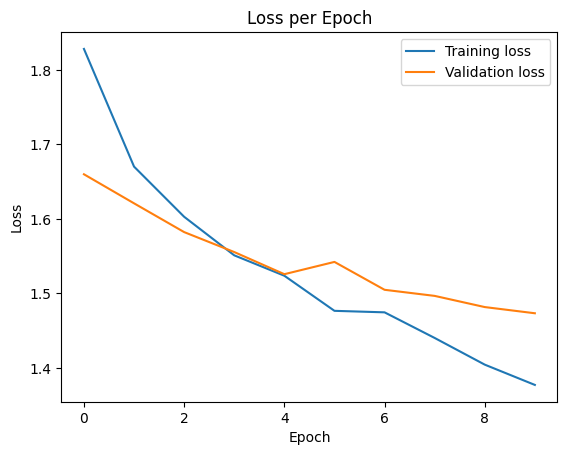

59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step
Weighted F1-Score: 0.40532758173922456


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Пути к вашему датасету
train_images_dir = '/content/affectnet-yolo-format/YOLO_format/train/images'
train_labels_dir = '/content/affectnet-yolo-format/YOLO_format/train/labels'
val_images_dir = '/content/affectnet-yolo-format/YOLO_format/valid/images'
val_labels_dir = '/content/affectnet-yolo-format/YOLO_format/valid/labels'

# Количество классов
num_classes = 8  # Подгоните под ваш датасет

# Функция загрузки данных
def load_data(images_dir, labels_dir):
    images = []
    labels = []

    for image_name in sorted(os.listdir(images_dir)):
        image_path = os.path.join(images_dir, image_name)
        label_path = os.path.join(labels_dir, image_name.replace('.png', '.txt'))

        if not os.path.exists(label_path):
            continue

        # Загрузка и предобработка изображения
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)
        images.append(image)

        # Загрузка меток (извлекаем только class ID из первой строки файла)
        with open(label_path, 'r') as file:
            first_line = file.readline().strip()
            class_id = int(first_line.split()[0])  # Извлекаем class ID
            labels.append(class_id)

    images = np.array(images) / 255.0  # Нормализация изображений
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)  # One-hot encoding
    return images, labels

# Загрузка данных
train_images, train_labels = load_data(train_images_dir, train_labels_dir)
val_images, val_labels = load_data(val_images_dir, val_labels_dir)

# Создание модели MobileNetV2
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Обучение модели
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    batch_size=32,
    epochs=10
)

# Функция для отображения графиков
def plot_metrics(history, metrics=['accuracy', 'loss']):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric.capitalize()} per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

# Отображение метрик accuracy и loss
plot_metrics(history, metrics=['accuracy', 'loss'])

# Вычисление F1-score
predictions = model.predict(val_images)
predictions = np.argmax(predictions, axis=1)
true_labels = np.argmax(val_labels, axis=1)

f1 = f1_score(true_labels, predictions, average='weighted')
print("Weighted F1-Score:", f1)

Epoch 1/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 121s 480ms/step - accuracy: 0.2102 - loss: 13.6373 - val_accuracy: 0.3796 - val_loss: 12.1935
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 51s 311ms/step - accuracy: 0.3452 - loss: 12.3670 - val_accuracy: 0.4108 - val_loss: 12.0954
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 51s 313ms/step - accuracy: 0.4162 - loss: 11.4923 - val_accuracy: 0.3946 - val_loss: 12.0345
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 50s 311ms/step - accuracy: 0.4516 - loss: 10.8385 - val_accuracy: 0.4538 - val_loss: 10.7012
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 50s 309ms/step - accuracy: 0.4874 - loss: 10.2343 - val_accuracy: 0.4978 - val_loss: 9.9162
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.5061 - loss: 9.6801 - val_accuracy: 0.5414 - val_loss: 9.2575
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 50s 311ms/step - accuracy: 0.5408 - loss: 9.0882 - val_accuracy: 0.5656 - val_loss: 8.6799
Epoch 8/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.5541

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


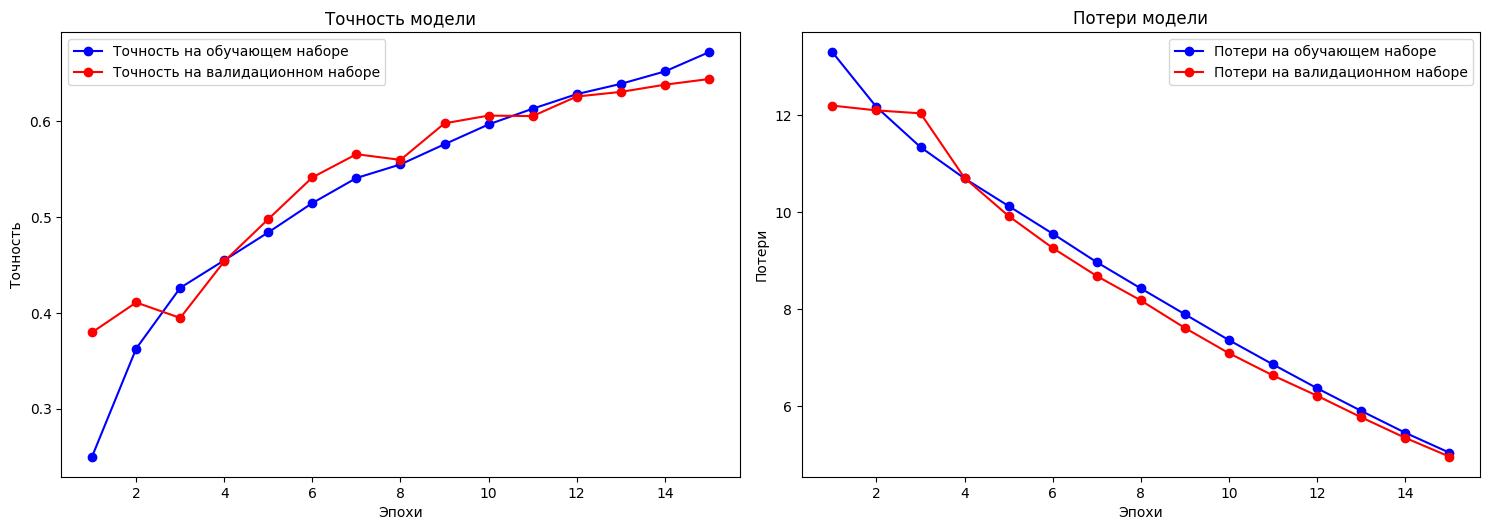

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Аугментация данных
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_images_augmented = data_gen.flow(train_images, train_labels, batch_size=32)

# Создание модели
num_classes = 8  # Количество классов
enhanced_model = models.Sequential([
    tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.6),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.6),
    layers.Dense(num_classes, activation='softmax')
])

# Компиляция модели
enhanced_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Обучение модели с выводом отчета о классификации
enhanced_history = enhanced_model.fit(
    train_images_augmented,
    validation_data=(val_images, val_labels),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop]
)

# Прогнозирование на валидационной выборке
y_pred = enhanced_model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Получение истинных меток
true_classes = np.argmax(val_labels, axis=1)

# Вывод отчета о классификации
target_names = [f'class_{i}' for i in range(num_classes)]
print("Classification Report:")
print(classification_report(true_classes, y_pred_classes, target_names=target_names))

# Извлечение метрик из истории обучения
accuracy = enhanced_history.history['accuracy']
val_accuracy = enhanced_history.history['val_accuracy']
loss = enhanced_history.history['loss']
val_loss = enhanced_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

# Создание графиков
plt.figure(figsize=(15, 10))

# График точности
plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Точность на обучающем наборе')
plt.plot(epochs, val_accuracy, 'ro-', label='Точность на валидационном наборе')
plt.title('Точность модели')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

# График потерь
plt.subplot(2, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Потери на обучающем наборе')
plt.plot(epochs, val_loss, 'ro-', label='Потери на валидационном наборе')
plt.title('Потери модели')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
# Install YOLOv5 dependencies
!git clone https://github.com/ultralytics/yolov5.git
!pip install -r /content/yolov5/requirements.txt

# Install PyTorch for Faster R-CNN
!pip install torch torchvision

Cloning into 'yolov5'...
remote: Enumerating objects: 17055, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 17055 (delta 17), reused 16 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17055/17055), 15.67 MiB | 13.92 MiB/s, done.
Resolving deltas: 100% (11712/11712), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 55.3 MB/s eta 0:00:00


In [5]:
!pip install -r /content/yolov5/requirements.txt
# Change directory to yolov5
%cd yolov5

# Train YOLOv5 on your dataset
!python train.py --img 640 --batch 16 --epochs 25 --data /content/affectnet-yolo-format/YOLO_format/data.yaml --weights yolov5s.pt

Выходные данные были обрезаны до нескольких последних строк (5000).
      22/24      4.72G   0.001645   0.001566    0.03056         55        640:  68% 723/1069 [01:00<00:27, 12.74it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      22/24      4.72G   0.001645   0.001566    0.03056         50        640:  68% 723/1069 [01:00<00:27, 12.74it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      22/24      4.72G   0.001645   0.001566    0.03056         55        640:  68% 725/1069 [01:00<00:27, 12.32it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      22/24